* Pre-trained vgg16 transfer learning

In [2]:
import glob
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from sklearn import manifold
import chainer
import chainer.functions as F
import chainer.links as L
from PIL import Image
from tqdm import tqdm

* how to use pre-trained vgg16 by chainer

In [3]:
vgg = L.VGG16Layers()

Now loading caffemodel (usually it may take few minutes)


In [4]:
vgg._children

{'conv1_1',
 'conv1_2',
 'conv2_1',
 'conv2_2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'conv5_1',
 'conv5_2',
 'conv5_3',
 'fc6',
 'fc7',
 'fc8'}

* get img feature by pre-trained vgg16 

In [5]:
paths = []
features = []

for path in tqdm(glob.glob('./data/flower_images/*.png')):
    
    paths.append(path)
    
    img = Image.open(path)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    feature = vgg.extract([img], layers=['fc7'])['fc7']
    feature = feature.data.reshape(-1)
    features.append(feature)
    
features = np.array(features)

100%|██████████| 210/210 [01:53<00:00,  1.84it/s]


* calc similarity

In [6]:
def cos_sim_matrix(matrix):
    
    d = matrix @ matrix.T
    norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5
    return d / norm / norm.T

In [7]:
cos_sims = cos_sim_matrix(features)

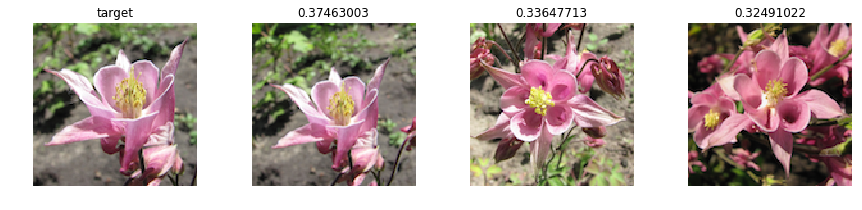

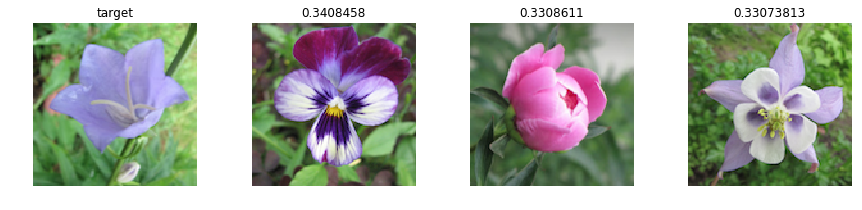

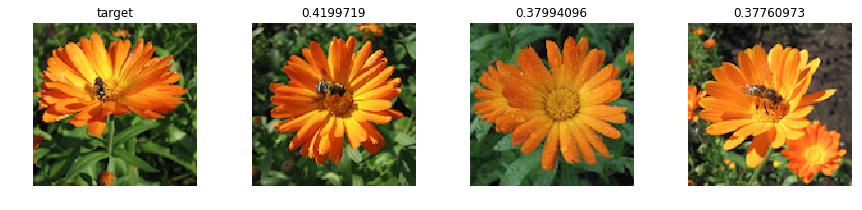

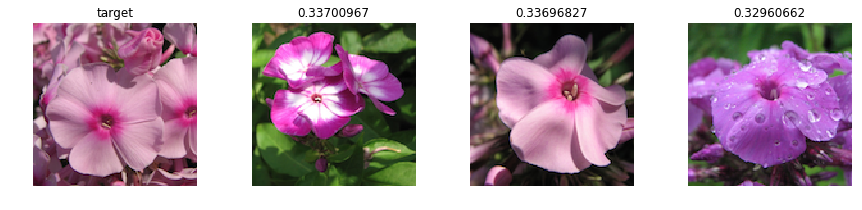

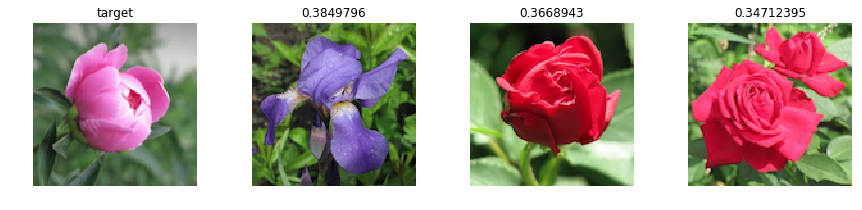

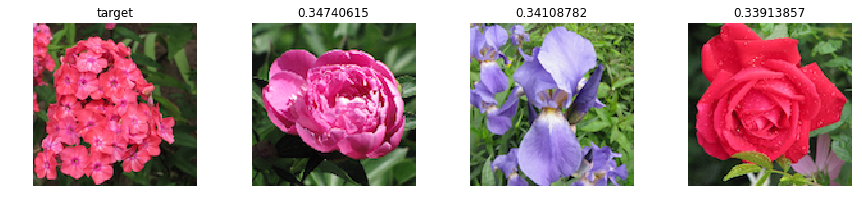

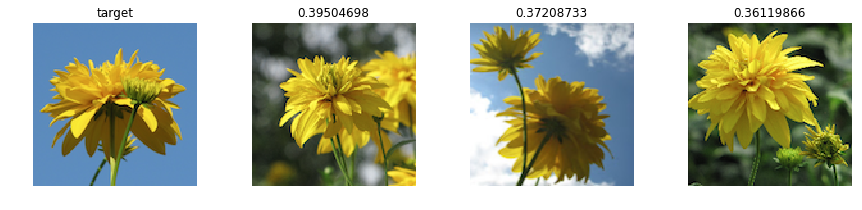

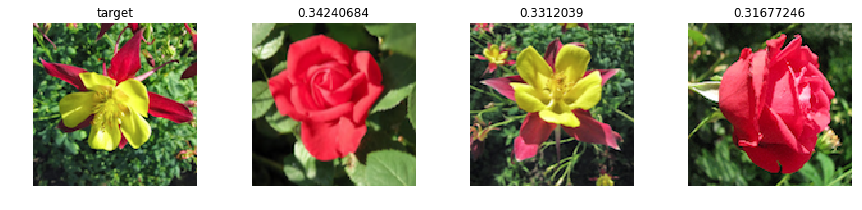

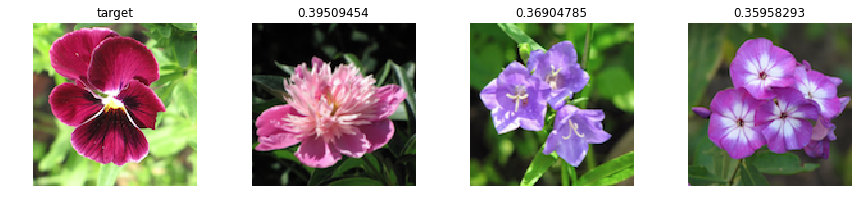

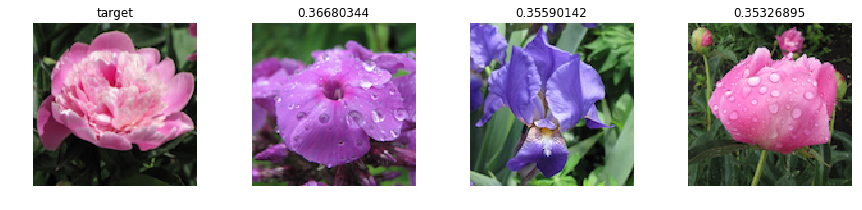

In [8]:
samples = np.random.randint(0, len(paths), 10)

for i in samples:
    
    sim_idxs = np.argsort(cos_sims[i])[::-1]
    sim_idxs = np.delete(sim_idxs, np.where(sim_idxs==i))
    
    sim_num = 3
    sim_idxs = sim_idxs[:sim_num]
    fig, axs = plt.subplots(ncols=sim_num+1, figsize=(15, sim_num))
    img = Image.open(paths[i])
    axs[0].imshow(img)
    axs[0].set_title('target')
    axs[0].axis('off')
    
    for j in range(sim_num):
        img = Image.open(paths[sim_idxs[j]])
        axs[j+1].imshow(img)
        axs[j+1].set_title(cos_sims[i, sim_idxs[j]])
        axs[j+1].axis('off')
        
    plt.show()

* plot t-sne map of img features

In [9]:
tsne_model = manifold.TSNE(n_components=2).fit_transform(features)

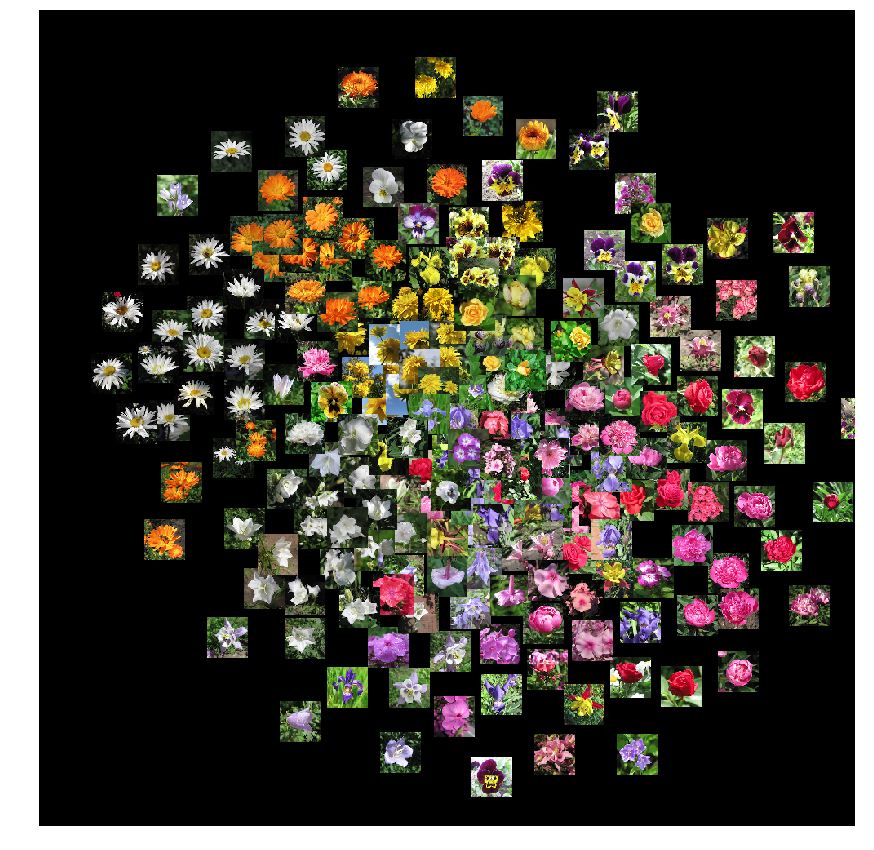

In [31]:
canvas_size = (1000, 1000)
img_size = (50, 50)
canvas = Image.new('RGB', canvas_size)

val_max = tsne_model.max()
val_min = tsne_model.min()
wide_param = 3.0

for i, path in enumerate(paths):
    
    pos_x = int(tsne_model[i][0]*(canvas_size[0]/img_size[0])/(val_max-val_min)*img_size[0]*wide_param+canvas_size[0]/2)
    pos_y = int(tsne_model[i][1]*(canvas_size[1]/img_size[1])/(val_max-val_min)*img_size[1]*wide_param+canvas_size[1]/2)
    
    target_img = Image.open(path)
    target_img = target_img.resize(img_size)
    canvas.paste(target_img, (pos_x, pos_y))
    target_img.close()
    
plt.figure(figsize=(15,15))
plt.imshow(np.array(canvas))
plt.axis('off')
plt.show()

In [32]:
!python --version

Python 3.6.3


In [33]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
certifi==2018.4.16
chainer==4.0.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
kaggle==1.4.5
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0.2.0
pexpect==4.5.0
pickleshare==0.7.4
Pillow==5.1.0
prompt-toolkit==1.0.15
protobuf==3.5.2.post1
ptyprocess==0.5.2
pycurl==7.43.0
Pygments==

In [34]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [35]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
